In [4]:
# Section 1: Environment setup, data download, preprocessing, FastText embeddings, dataset creation
# Run in Google Colab.

# 0) Install required packages (run once)
!pip install --quiet kaggle gensim==4.3.1 nltk tqdm torch torchvision torchaudio scikit-learn pandas numpy

# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Kaggle setup: put your kaggle.json into your Drive at path:
#    /content/drive/MyDrive/kaggle/kaggle.json
# If you haven't uploaded kaggle.json to drive, upload it now manually:
# - Go to https://www.kaggle.com -> Account -> create API token -> download kaggle.json
# - Upload to your Drive at above path.
import os
KAGGLE_JSON_PATH = "/content/drive/MyDrive/kaggle/kaggle.json"
if not os.path.exists(KAGGLE_JSON_PATH):
    raise FileNotFoundError(f"kaggle.json not found at {KAGGLE_JSON_PATH}. Please upload it to your Drive.")

# 3) Configure kaggle
os.makedirs("/root/.kaggle", exist_ok=True)
!cp "{KAGGLE_JSON_PATH}" /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# 4) Download dataset from Kaggle into /content/data
DATA_DIR = "/content/drive/MyDrive/Datasets/nlp/legal_clauses"
os.makedirs(DATA_DIR, exist_ok=True)

# Kaggle dataset: bahushruth/legalclausedataset
!kaggle datasets download -d bahushruth/legalclausedataset -p "{DATA_DIR}" --unzip

# Confirm files
import glob, pprint
files = glob.glob(DATA_DIR + "/*.csv")
print("CSV files downloaded:")
pprint.pp(files)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 59.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gensim
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (gensim)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/bahushruth/legalclausedataset
License(s): CC0-1.0
  0% 0.00/19.4M [00:00<?, ?B/s]
100% 19.4M/19.4M [00:00<00:00, 379MB/s]
CSV files downloaded:
['/content/drive/MyDrive/Datasets/nlp/legal_clauses/absence-of-certain-changes-or-events.csv',
 '/content/drive/MyDrive/Datasets/nlp/legal_clauses/absence-of-certain-changes.csv',
 '/cont

In [3]:
# 5) Imports for preprocessing, tokenization, embeddings
import re
import random
import json
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import nltk
from tqdm import tqdm
nltk.download('punkt')
nltk.download('punkt_tab')

# 6) Read all CSVs into a single DataFrame. Each CSV file corresponds to a clause category.
def load_all_csvs(data_dir):
    import glob, os
    files = glob.glob(os.path.join(data_dir, "*.csv"))
    df_list = []
    for f in files:
        df = pd.read_csv(f)
        # Ensure columns - try to be robust:
        # Expecting something like columns ['clause','type'] or similar; inspect head
        df.columns = [c.strip() for c in df.columns]
        # rename heuristics
        colnames = df.columns.tolist()
        if 'clause' in [c.lower() for c in colnames]:
            clause_col = [c for c in colnames if c.lower() == 'clause'][0]
        else:
            # try first text-like column
            clause_col = colnames[0]
        if 'type' in [c.lower() for c in colnames]:
            type_col = [c for c in colnames if c.lower() == 'type'][0]
        elif 'clause_type' in [c.lower() for c in colnames]:
            type_col = [c for c in colnames if c.lower() == 'clause_type'][0]
        else:
            # derive type from filename if missing
            type_col = None

        if type_col is None:
            label = os.path.splitext(os.path.basename(f))[0]
            df2 = pd.DataFrame({
                'clause_text': df[clause_col].astype(str).tolist(),
                'clause_type': [label]*len(df)
            })
        else:
            df2 = pd.DataFrame({
                'clause_text': df[clause_col].astype(str),
                'clause_type': df[type_col].astype(str)
            })
        df2['source_file'] = os.path.basename(f)
        df_list.append(df2)
    all_df = pd.concat(df_list, ignore_index=True)
    return all_df

df = load_all_csvs(DATA_DIR)
print("Total clauses:", len(df))
display(df.head(6))

# 7) Basic cleaning function
def clean_text(text):
    # Keep punctuation (legal wording matters), but normalize whitespace and quotes
    s = str(text)
    s = s.replace('\n', ' ').replace('\r', ' ')
    s = re.sub(r'\s+', ' ', s).strip()
    # Optionally lower-case
    s = s.strip()
    return s

df['clause_text'] = df['clause_text'].astype(str).apply(clean_text)

# 8) Remove duplicates (exact duplicates) to avoid leakage
before = len(df)
df = df.drop_duplicates(subset=['clause_text']).reset_index(drop=True)
after = len(df)
print(f"Removed {before-after} exact duplicate clauses. Remaining: {after}")

# 9) Compute clause length stats
df['num_words'] = df['clause_text'].apply(lambda x: len(nltk.word_tokenize(x)))
print(df['num_words'].describe())
# Optionally filter extremely long clauses if any
MAX_LEN_WORDS = 200
df = df[df['num_words'] <= MAX_LEN_WORDS].reset_index(drop=True)
print("After filtering long clauses:", len(df))

# 10) Prepare unique clause IDs to ensure splitting by clause (prevent leakage)
df['clause_id'] = df.index.astype(str)  # unique id per clause

# 11) Stratified split of unique clauses into train/val/test by clause_type
# We split clauses (rows) directly so no leakage occurs.
train_frac = 0.70
val_frac = 0.15
test_frac = 0.15
assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6

# We'll do stratified split by clause_type where possible.
def stratified_split_df(df, train_frac=0.7, val_frac=0.15, test_frac=0.15, random_state=42):
    train_rows = []
    val_rows = []
    test_rows = []
    rng = np.random.RandomState(random_state)
    for t, group in df.groupby('clause_type'):
        rows = group.sample(frac=1, random_state=random_state).reset_index(drop=True)
        n = len(rows)
        n_train = int(np.round(train_frac * n))
        n_val = int(np.round(val_frac * n))
        # guard for very small classes
        if n < 3:
            # put 1 into each of train/val/test if possible
            if n == 1:
                train_rows.append(rows.iloc[[0]])
            elif n == 2:
                train_rows.append(rows.iloc[[0]])
                val_rows.append(rows.iloc[[1]])
            continue
        train_rows.append(rows.iloc[:n_train])
        val_rows.append(rows.iloc[n_train:n_train+n_val])
        test_rows.append(rows.iloc[n_train+n_val:])
    train_df = pd.concat(train_rows).sample(frac=1, random_state=random_state).reset_index(drop=True)
    val_df = pd.concat(val_rows).sample(frac=1, random_state=random_state).reset_index(drop=True) if len(val_rows)>0 else pd.DataFrame(columns=df.columns)
    test_df = pd.concat(test_rows).sample(frac=1, random_state=random_state).reset_index(drop=True) if len(test_rows)>0 else pd.DataFrame(columns=df.columns)
    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_split_df(df, train_frac, val_frac, test_frac, random_state=123)
print("Train clauses:", len(train_df), "Val clauses:", len(val_df), "Test clauses:", len(test_df))

# 12) Pair generation function (balanced positive & negative pairs)
def generate_pairs(df_clauses, max_pairs_per_class=5000, seed=42):
    """
    df_clauses: DataFrame of clauses (for a split)
    For each clause type, create positive pairs by sampling combinations,
    and create negative pairs by pairing with clauses from other types.
    Returns DataFrame with columns: clause_id_a, clause_id_b, text_a, text_b, label (1 similar, 0 not similar)
    """
    rng = np.random.RandomState(seed)
    pairs = []
    by_type = {t: g for t, g in df_clauses.groupby('clause_type')}
    types = list(by_type.keys())
    for t in types:
        group = by_type[t]
        ids = group['clause_id'].tolist()
        texts = group['clause_text'].tolist()
        n = len(ids)
        # Positive pairs: all combinations if small, else sample
        pos_pairs = []
        if n < 2:
            pos_pairs = []
        else:
            # create all combinations if not too many
            max_possible = n*(n-1)//2
            if max_possible <= max_pairs_per_class:
                for i in range(n):
                    for j in range(i+1, n):
                        pos_pairs.append((ids[i], ids[j], texts[i], texts[j], 1))
            else:
                # sample random positive pairs
                for _ in range(max_pairs_per_class):
                    i, j = rng.choice(n, size=2, replace=False)
                    pos_pairs.append((ids[i], ids[j], texts[i], texts[j], 1))
        pairs.extend(pos_pairs)

        # Negative pairs: sample equal number as positive pairs by pairing group items with other types
        neg_pairs = []
        if len(pos_pairs) > 0:
            other_types = [ot for ot in types if ot != t]
            other_ids_texts = []
            for ot in other_types:
                other_ids_texts.extend(list(zip(by_type[ot]['clause_id'].tolist(), by_type[ot]['clause_text'].tolist())))
            if len(other_ids_texts) == 0:
                # no negatives possible; skip
                pass
            else:
                for _ in range(len(pos_pairs)):
                    a_idx = rng.choice(n)
                    b_idx = rng.randint(len(other_ids_texts))
                    b_id, b_text = other_ids_texts[b_idx]
                    neg_pairs.append((ids[a_idx], b_id, texts[a_idx], b_text, 0))
                pairs.extend(neg_pairs)
    pairs_df = pd.DataFrame(pairs, columns=['clause_id_a','clause_id_b','text_a','text_b','label'])
    # Shuffle
    pairs_df = pairs_df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return pairs_df

# Generate pairs for train/val/test (you can control max_pairs_per_class to limit dataset size)
MAX_PAIRS_PER_CLASS = 500  # tweak for memory / compute limits
train_pairs = generate_pairs(train_df, max_pairs_per_class=MAX_PAIRS_PER_CLASS, seed=123)
val_pairs = generate_pairs(val_df, max_pairs_per_class=MAX_PAIRS_PER_CLASS, seed=123)
test_pairs = generate_pairs(test_df, max_pairs_per_class=MAX_PAIRS_PER_CLASS, seed=123)
print("Train pairs:", len(train_pairs), "Val pairs:", len(val_pairs), "Test pairs:", len(test_pairs))

# 13) Tokenizer: simple word-level tokenizer using nltk.word_tokenize and build vocab
from collections import defaultdict

def build_vocab(sentences, min_freq=2, max_vocab_size=30000):
    freq = Counter()
    for s in sentences:
        toks = nltk.word_tokenize(s.lower())
        freq.update(toks)
    # keep most common
    most_common = [w for w, c in freq.most_common(max_vocab_size) if c >= min_freq]
    # create mappings: reserve 0 for PAD, 1 for UNK
    stoi = {'<PAD>':0, '<UNK>':1}
    for i, w in enumerate(most_common, start=2):
        stoi[w] = i
    itos = {i:w for w,i in stoi.items()}
    return stoi, itos, freq

all_texts = pd.concat([train_df['clause_text'], val_df['clause_text'], test_df['clause_text']]).unique().tolist()
print("Unique clause texts total:", len(all_texts))
stoi, itos, freq = build_vocab(all_texts, min_freq=1, max_vocab_size=30000)
vocab_size = len(stoi)
print("Vocab size:", vocab_size)

def text_to_sequence(text, stoi, max_len=128):
    toks = nltk.word_tokenize(text.lower())
    seq = [stoi.get(t, stoi['<UNK>']) for t in toks][:max_len]
    if len(seq) < max_len:
        seq = seq + [stoi['<PAD>']]*(max_len - len(seq))
    return seq

MAX_SEQ_LEN = 128

# Convert pairs to sequences and save as numpy arrays to speedup later runs
def pairs_to_sequences(pairs_df, stoi, max_len=MAX_SEQ_LEN):
    A_seqs = []
    B_seqs = []
    labels = []
    for _, row in tqdm(pairs_df.iterrows(), total=len(pairs_df)):
        A_seqs.append(text_to_sequence(row['text_a'], stoi, max_len))
        B_seqs.append(text_to_sequence(row['text_b'], stoi, max_len))
        labels.append(int(row['label']))
    return np.array(A_seqs, dtype=np.int64), np.array(B_seqs, dtype=np.int64), np.array(labels, dtype=np.int64)

train_A, train_B, train_y = pairs_to_sequences(train_pairs, stoi, MAX_SEQ_LEN)
val_A, val_B, val_y = pairs_to_sequences(val_pairs, stoi, MAX_SEQ_LEN)
test_A, test_B, test_y = pairs_to_sequences(test_pairs, stoi, MAX_SEQ_LEN)

print("Train shapes:", train_A.shape, train_B.shape, train_y.shape)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Total clauses: 150881


,clause_text,clause_type,source_file
0,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events.csv
1,Absence of Certain Changes or Events. Since Ma...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events.csv
2,Absence of Certain Changes or Events. (a) Sinc...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events.csv
3,Absence of Certain Changes or Events. Since th...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events.csv
4,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events.csv
5,Absence of Certain Changes or Events. Since Ma...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events.csv


Removed 336 exact duplicate clauses. Remaining: 150545
count    150545.000000
mean        109.218984
std         101.235202
min           2.000000
25%          39.000000
50%          75.000000
75%         142.000000
max        1035.000000
Name: num_words, dtype: float64
After filtering long clauses: 128534
Train clauses: 89972 Val clauses: 19272 Test clauses: 19290
Train pairs: 391766 Val pairs: 369146 Test pairs: 369352
Unique clause texts total: 128534
Vocab size: 30002


100%|██████████| 369352/369352 [05:05<00:00, 1208.48it/s]


Train shapes: (391766, 128) (391766, 128) (391766,)


ModuleNotFoundError: No module named 'gensim'

In [6]:
!pip install --upgrade --no-cache-dir gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 347.8 MB/s eta 0:00:00


In [7]:
import gensim
print("Gensim version:", gensim.__version__)


Gensim version: 4.4.0


In [9]:

# 14) Train FastText embeddings on the clause corpus using gensim FastText (train on the dataset - not using external pretrained vectors)
from gensim.models import FastText
# Prepare corpus: list of token lists
corpus = [nltk.word_tokenize(s.lower()) for s in all_texts]

EMBED_DIM = 100  # fasttext vector dim; small enough for T4
print("Training FastText on corpus (this may take ~1-3 minutes depending on size)...")
ft_model = FastText(vector_size=EMBED_DIM, window=5, min_count=1, workers=4, sg=1)
ft_model.build_vocab(corpus_iterable=corpus)
ft_model.train(corpus_iterable=corpus, total_examples=len(corpus), epochs=10)

# 15) Build embedding matrix aligned with our stoi
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, EMBED_DIM)).astype(np.float32)
for word, idx in stoi.items():
    if word in ['<PAD>','<UNK>']:
        continue
    if word in ft_model.wv:
        embedding_matrix[idx] = ft_model.wv[word]
# For PAD token set zeros
embedding_matrix[stoi['<PAD>']] = np.zeros(EMBED_DIM, dtype=np.float32)

print("Embedding matrix shape:", embedding_matrix.shape)

# Save prepared numpy arrays and supporting objects to Drive to avoid repeating
OUT_DIR = "/content/drive/MyDrive/legal_clause_preprocessed"
os.makedirs(OUT_DIR, exist_ok=True)
np.save(os.path.join(OUT_DIR, "train_A.npy"), train_A)
np.save(os.path.join(OUT_DIR, "train_B.npy"), train_B)
np.save(os.path.join(OUT_DIR, "train_y.npy"), train_y)
np.save(os.path.join(OUT_DIR, "val_A.npy"), val_A)
np.save(os.path.join(OUT_DIR, "val_B.npy"), val_B)
np.save(os.path.join(OUT_DIR, "val_y.npy"), val_y)
np.save(os.path.join(OUT_DIR, "test_A.npy"), test_A)
np.save(os.path.join(OUT_DIR, "test_B.npy"), test_B)
np.save(os.path.join(OUT_DIR, "test_y.npy"), test_y)
np.save(os.path.join(OUT_DIR, "embedding_matrix.npy"), embedding_matrix)
with open(os.path.join(OUT_DIR, "stoi.json"), "w") as f:
    json.dump(stoi, f)
print("Saved preprocessed arrays and embedding matrix to", OUT_DIR)

# 16) Build PyTorch Dataset and DataLoader
import torch
from torch.utils.data import Dataset, DataLoader

class ClausePairDataset(Dataset):
    def __init__(self, A_seqs, B_seqs, labels):
        self.A = torch.tensor(A_seqs, dtype=torch.long)
        self.B = torch.tensor(B_seqs, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.A[idx], self.B[idx], self.labels[idx]

# Create datasets
train_dataset = ClausePairDataset(train_A, train_B, train_y)
val_dataset = ClausePairDataset(val_A, val_B, val_y)
test_dataset = ClausePairDataset(test_A, test_B, test_y)

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders ready. Sample batch:")
batch = next(iter(train_loader))
print([b.shape for b in batch])  # A_seq, B_seq, labels

# 17) Device detection and helper
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Save device info and paths for downstream cells
CONFIG = {
    'data_dir': DATA_DIR,
    'preproc_dir': OUT_DIR,
    'vocab_size': vocab_size,
    'embed_dim': EMBED_DIM,
    'max_seq_len': MAX_SEQ_LEN,
    'batch_size': BATCH_SIZE,
    'device': str(device)
}
with open(os.path.join(OUT_DIR, "config.json"), "w") as f:
    json.dump(CONFIG, f)

print("Section 1 complete: data downloaded, preprocessed, FastText embeddings trained, DataLoaders ready.")

Training FastText on corpus (this may take ~1-3 minutes depending on size)...
Embedding matrix shape: (30002, 100)
Saved preprocessed arrays and embedding matrix to /content/drive/MyDrive/legal_clause_preprocessed
DataLoaders ready. Sample batch:
[torch.Size([32, 128]), torch.Size([32, 128]), torch.Size([32])]
Using device: cuda
Section 1 complete: data downloaded, preprocessed, FastText embeddings trained, DataLoaders ready.


In [1]:
# Section 2: PyTorch models (BiLSTM and Attention encoder), training loop, evaluation, checkpointing
# Run after Section 1 in the same Colab session.

import os
import json
import time
import copy
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------------
# Load preprocessed data & embedding matrix config from Drive
# -------------------------
OUT_DIR = "/content/drive/MyDrive/legal_clause_preprocessed"
with open(os.path.join(OUT_DIR, "config.json"), "r") as f:
    CONFIG = json.load(f)

vocab_size = CONFIG['vocab_size']
EMBED_DIM = CONFIG['embed_dim']
MAX_SEQ_LEN = CONFIG['max_seq_len']
BATCH_SIZE = CONFIG['batch_size']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

embedding_matrix = np.load(os.path.join(OUT_DIR, "embedding_matrix.npy"))
print("Loaded embedding matrix:", embedding_matrix.shape)

# reload DataLoaders quickly by reloading numpy arrays and creating DataLoader (fast restart friendly)
train_A = np.load(os.path.join(OUT_DIR, "train_A.npy"))
train_B = np.load(os.path.join(OUT_DIR, "train_B.npy"))
train_y = np.load(os.path.join(OUT_DIR, "train_y.npy"))
val_A = np.load(os.path.join(OUT_DIR, "val_A.npy"))
val_B = np.load(os.path.join(OUT_DIR, "val_B.npy"))
val_y = np.load(os.path.join(OUT_DIR, "val_y.npy"))
test_A = np.load(os.path.join(OUT_DIR, "test_A.npy"))
test_B = np.load(os.path.join(OUT_DIR, "test_B.npy"))
test_y = np.load(os.path.join(OUT_DIR, "test_y.npy"))

from torch.utils.data import Dataset, DataLoader

class ClausePairDataset(Dataset):
    def __init__(self, A_seqs, B_seqs, labels):
        self.A = torch.tensor(A_seqs, dtype=torch.long)
        self.B = torch.tensor(B_seqs, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.A[idx], self.B[idx], self.labels[idx]

train_dataset = ClausePairDataset(train_A, train_B, train_y)
val_dataset = ClausePairDataset(val_A, val_B, val_y)
test_dataset = ClausePairDataset(test_A, test_B, test_y)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Device: cuda
Loaded embedding matrix: (30002, 100)


In [2]:
# -------------------------
# Model definitions
# -------------------------
class BiLSTMClassifier(nn.Module):
    """
    Baseline 1: BiLSTM encoder for each clause separately (shared weights),
    Pooling (max + avg), combine pair features and classify.
    """
    def __init__(self, vocab_size, embed_dim, embedding_matrix=None, hidden_size=128, num_layers=1,
                 dropout=0.3, freeze_emb=False):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = not freeze_emb

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers, batch_first=True,
                              bidirectional=True, dropout=dropout if num_layers>1 else 0.0)
        # Pooling will produce 4*hidden_size (avg+max for each direction combined)
        combined_dim = 4 * hidden_size
        # After combining two clause vectors (u, v, |u-v|, u*v) dims -> 4 * combined_dim
        classifier_input_dim = 4 * combined_dim
        self.fc = nn.Sequential(
            nn.Linear(classifier_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def encode(self, input_ids):
        # input_ids: (batch, seq_len)
        emb = self.embedding(input_ids)  # (batch, seq_len, emb)
        outputs, _ = self.bilstm(emb)     # (batch, seq_len, 2*hidden)
        # Pooling: avg and max across time
        avg_pool = torch.mean(outputs, dim=1)         # (batch, 2*hidden)
        max_pool, _ = torch.max(outputs, dim=1)       # (batch, 2*hidden)
        # Concatenate avg and max
        rep = torch.cat([avg_pool, max_pool], dim=1)  # (batch, 4*hidden/??) -> careful: hidden is per-direction
        # Note: outputs dim is 2*hidden, so rep dim = 4*hidden
        return rep

    def forward(self, a_ids, b_ids):
        ua = self.encode(a_ids)
        ub = self.encode(b_ids)
        diff = torch.abs(ua - ub)
        mul = ua * ub
        features = torch.cat([ua, ub, diff, mul], dim=1)
        logits = self.fc(features).squeeze(1)
        return logits  # raw logits (before sigmoid)


class AttentionEncoderClassifier(nn.Module):
    """
    Baseline 2: Attention-based encoder.
    We compute attention weights over BiLSTM hidden states using a learned projection.
    """
    def __init__(self, vocab_size, embed_dim, embedding_matrix=None, hidden_size=128, num_layers=1,
                 attn_hidden=128, dropout=0.3, freeze_emb=False):
        super(AttentionEncoderClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = not freeze_emb

        self.bilstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers, batch_first=True,
                              bidirectional=True, dropout=dropout if num_layers>1 else 0.0)
        # Attention projection
        # We'll compute attention scores: score = v^T * tanh(W * H + b)  where H: (batch, seq_len, 2*hidden)
        self.W = nn.Linear(2*hidden_size, attn_hidden, bias=True)
        self.v = nn.Linear(attn_hidden, 1, bias=False)
        # classifier input dim similar as above
        combined_dim = 2 * hidden_size  # will use attended vector of size 2*hidden
        classifier_input_dim = 4 * combined_dim
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def attend(self, outputs):
        # outputs: (batch, seq_len, 2*hidden)
        # compute attention scores
        u = torch.tanh(self.W(outputs))      # (batch, seq_len, attn_hidden)
        scores = self.v(u).squeeze(-1)       # (batch, seq_len)
        alphas = torch.softmax(scores, dim=1)  # (batch, seq_len)
        # weighted sum
        context = torch.sum(outputs * alphas.unsqueeze(-1), dim=1)  # (batch, 2*hidden)
        return context, alphas

    def encode(self, input_ids):
        emb = self.embedding(input_ids)
        outputs, _ = self.bilstm(emb)  # (batch, seq_len, 2*hidden)
        context, alphas = self.attend(outputs)
        return context  # (batch, 2*hidden)

    def forward(self, a_ids, b_ids):
        ua = self.encode(a_ids)
        ub = self.encode(b_ids)
        diff = torch.abs(ua - ub)
        mul = ua * ub
        features = torch.cat([ua, ub, diff, mul], dim=1)
        logits = self.classifier(features).squeeze(1)
        return logits

# -------------------------
# Utilities: loss, metric computation, training loop
# -------------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    # ROC-AUC (requires both classes present)
    try:
        rocauc = roc_auc_score(y_true, y_probs)
    except Exception:
        rocauc = float('nan')
    try:
        prauc = average_precision_score(y_true, y_probs)
    except Exception:
        prauc = float('nan')
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': rocauc,
        'pr_auc': prauc
    }

def evaluate_model(model, dataloader, device):
    model.eval()
    ys = []
    ys_probs = []
    total_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        for a_ids, b_ids, labels in dataloader:
            a_ids = a_ids.to(device)
            b_ids = b_ids.to(device)
            labels = labels.to(device)
            logits = model(a_ids, b_ids)
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            ys_probs.extend(probs.tolist())
            ys.extend(labels.detach().cpu().numpy().tolist())
    ys = np.array(ys).astype(int)
    ys_probs = np.array(ys_probs)
    avg_loss = total_loss / len(dataloader.dataset)
    metrics = compute_metrics(ys, ys_probs, threshold=0.5)
    metrics['loss'] = avg_loss
    return metrics, ys, ys_probs

def train_model(model, train_loader, val_loader, device, num_epochs=10, lr=1e-3, weight_decay=1e-5,
                grad_clip=None, save_path=None, early_stopping_patience=3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = -1.0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    epochs_no_improve = 0

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        t0 = time.time()
        for a_ids, b_ids, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
            a_ids = a_ids.to(device)
            b_ids = b_ids.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(a_ids, b_ids)
            loss = criterion(logits, labels)
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            running_loss += loss.item() * labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        val_metrics, _, _ = evaluate_model(model, val_loader, device)
        val_loss = val_metrics['loss']
        val_f1 = val_metrics['f1']
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        epoch_time = time.time() - t0
        print(f"Epoch {epoch} finished in {epoch_time:.1f}s - train_loss: {train_loss:.4f} val_loss: {val_loss:.4f} val_f1: {val_f1:.4f}")

        # Checkpoint best by val_f1
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            if save_path is not None:
                torch.save(model.state_dict(), save_path)
                print(f"Saved best model to {save_path}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping after {epoch} epochs. Best val_f1: {best_f1:.4f}")
                break

    # load best weights
    model.load_state_dict(best_model_wts)
    return model, history


Sanity outputs shapes: torch.Size([32]) torch.Size([32])

Running experiment: BiLSTM_no_attention


Epoch 1/12: 100%|██████████| 12243/12243 [01:55<00:00, 105.69it/s]


Epoch 1 finished in 162.5s - train_loss: 0.0081 val_loss: 0.0014 val_f1: 0.9997
Saved best model to /content/drive/MyDrive/legal_clause_experiments/BiLSTM_no_attention_bilstm.pt


Epoch 2/12: 100%|██████████| 12243/12243 [01:57<00:00, 104.36it/s]


Epoch 2 finished in 165.1s - train_loss: 0.0020 val_loss: 0.0017 val_f1: 0.9996


Epoch 3/12: 100%|██████████| 12243/12243 [01:58<00:00, 103.67it/s]


Epoch 3 finished in 165.2s - train_loss: 0.0018 val_loss: 0.0020 val_f1: 0.9997


Epoch 4/12: 100%|██████████| 12243/12243 [01:58<00:00, 103.45it/s]


Epoch 4 finished in 165.2s - train_loss: 0.0021 val_loss: 0.0014 val_f1: 0.9997
Saved best model to /content/drive/MyDrive/legal_clause_experiments/BiLSTM_no_attention_bilstm.pt


Epoch 5/12: 100%|██████████| 12243/12243 [01:58<00:00, 103.68it/s]


Epoch 5 finished in 166.0s - train_loss: 0.0025 val_loss: 0.0009 val_f1: 0.9998
Saved best model to /content/drive/MyDrive/legal_clause_experiments/BiLSTM_no_attention_bilstm.pt


Epoch 6/12: 100%|██████████| 12243/12243 [01:57<00:00, 104.04it/s]


Epoch 6 finished in 165.5s - train_loss: 0.0022 val_loss: 0.0022 val_f1: 0.9996


Epoch 7/12: 100%|██████████| 12243/12243 [01:58<00:00, 103.35it/s]


Epoch 7 finished in 165.8s - train_loss: 0.0024 val_loss: 0.0066 val_f1: 0.9996


Epoch 8/12: 100%|██████████| 12243/12243 [01:59<00:00, 102.39it/s]


Epoch 8 finished in 167.8s - train_loss: 0.0024 val_loss: 0.0030 val_f1: 0.9997
Early stopping after 8 epochs. Best val_f1: 0.9998
Test metrics: {'accuracy': 0.9998077714483744, 'precision': 0.9996156906472095, 'recall': 1.0, 'f1': 0.9998078083930887, 'roc_auc': np.float64(0.9999769176716894), 'pr_auc': np.float64(0.9999702835801532), 'loss': 0.001169650433964474}
Saved results to /content/drive/MyDrive/legal_clause_experiments/BiLSTM_no_attention_results.json and preds to /content/drive/MyDrive/legal_clause_experiments/BiLSTM_no_attention_preds.npz


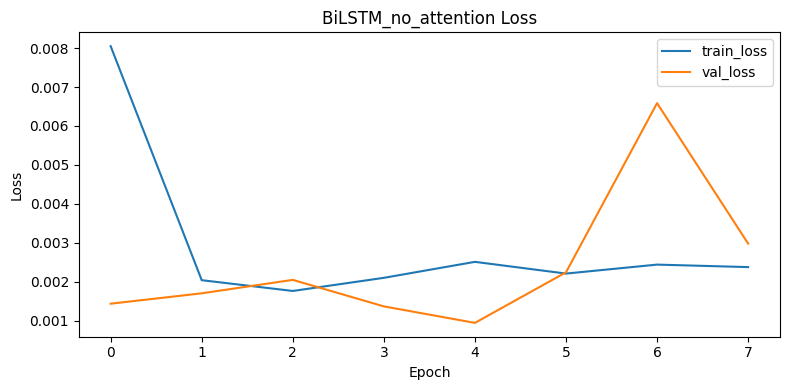

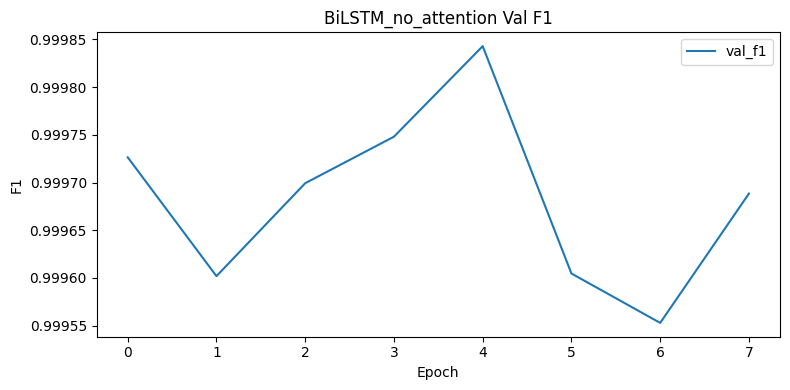


Running experiment: AttentionEncoder


Epoch 1/12: 100%|██████████| 12243/12243 [02:12<00:00, 92.75it/s]


Epoch 1 finished in 182.0s - train_loss: 0.0093 val_loss: 0.0019 val_f1: 0.9996
Saved best model to /content/drive/MyDrive/legal_clause_experiments/AttentionEncoder_attn.pt


Epoch 2/12: 100%|██████████| 12243/12243 [02:11<00:00, 92.82it/s]


Epoch 2 finished in 181.5s - train_loss: 0.0011 val_loss: 0.0012 val_f1: 0.9998
Saved best model to /content/drive/MyDrive/legal_clause_experiments/AttentionEncoder_attn.pt


Epoch 3/12: 100%|██████████| 12243/12243 [02:12<00:00, 92.33it/s]


Epoch 3 finished in 182.5s - train_loss: 0.0010 val_loss: 0.0009 val_f1: 0.9999
Saved best model to /content/drive/MyDrive/legal_clause_experiments/AttentionEncoder_attn.pt


Epoch 4/12: 100%|██████████| 12243/12243 [02:12<00:00, 92.32it/s]


Epoch 4 finished in 182.0s - train_loss: 0.0010 val_loss: 0.0011 val_f1: 0.9998


Epoch 5/12: 100%|██████████| 12243/12243 [02:12<00:00, 92.63it/s]


Epoch 5 finished in 182.2s - train_loss: 0.0008 val_loss: 0.0007 val_f1: 0.9998


Epoch 6/12: 100%|██████████| 12243/12243 [02:12<00:00, 92.17it/s]


Epoch 6 finished in 181.9s - train_loss: 0.0008 val_loss: 0.0010 val_f1: 0.9998
Early stopping after 6 epochs. Best val_f1: 0.9999
Test metrics: {'accuracy': 0.9999431436678291, 'precision': 0.999886300264758, 'recall': 1.0, 'f1': 0.9999431469002877, 'roc_auc': np.float64(0.9999989253845993), 'pr_auc': np.float64(0.9999987669950584), 'loss': 0.0002557854701308226}
Saved results to /content/drive/MyDrive/legal_clause_experiments/AttentionEncoder_results.json and preds to /content/drive/MyDrive/legal_clause_experiments/AttentionEncoder_preds.npz


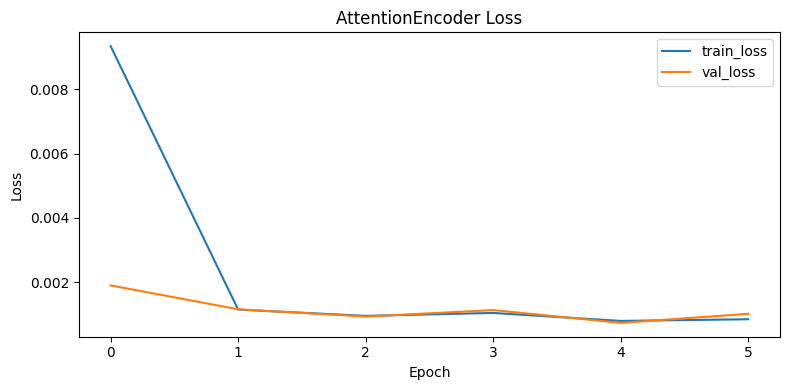

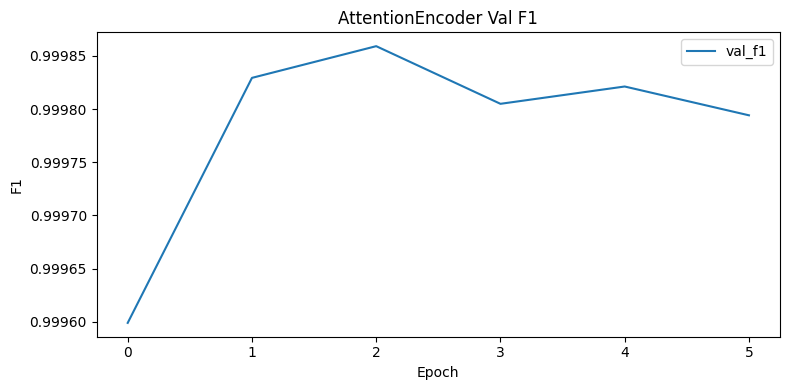

All experiments finished. Results saved in: /content/drive/MyDrive/legal_clause_experiments


In [3]:
# -------------------------
# Run experiments for both baselines
# -------------------------
EXPERIMENT_DIR = "/content/drive/MyDrive/legal_clause_experiments"
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

def run_experiment(model_name, model_obj, train_loader, val_loader, test_loader, device,
                   num_epochs=12, lr=1e-3, save_suffix=None):
    print(f"\nRunning experiment: {model_name}")
    save_path = os.path.join(EXPERIMENT_DIR, f"{model_name}_{save_suffix}.pt") if save_suffix else None
    # Train
    trained_model, history = train_model(model_obj, train_loader, val_loader, device,
                                         num_epochs=num_epochs, lr=lr, save_path=save_path,
                                         early_stopping_patience=3, grad_clip=5.0)
    # Evaluate on test
    test_metrics, ys_true, ys_probs = evaluate_model(trained_model, test_loader, device)
    print("Test metrics:", test_metrics)
    # Save history and metrics
    out = {
        'model_name': model_name,
        'history': history,
        'test_metrics': test_metrics
    }
    out_path = os.path.join(EXPERIMENT_DIR, f"{model_name}_results.json")
    with open(out_path, "w") as f:
        json.dump(out, f, indent=2)
    # Save predictions
    preds_path = os.path.join(EXPERIMENT_DIR, f"{model_name}_preds.npz")
    np.savez(preds_path, y_true=ys_true, y_probs=ys_probs)
    print(f"Saved results to {out_path} and preds to {preds_path}")

    # Plot training curves
    plt.figure(figsize=(8,4))
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"{model_name} Loss")
    plt.tight_layout()
    plt.savefig(os.path.join(EXPERIMENT_DIR, f"{model_name}_loss.png"))
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(history['val_f1'], label='val_f1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title(f"{model_name} Val F1")
    plt.tight_layout()
    plt.savefig(os.path.join(EXPERIMENT_DIR, f"{model_name}_f1.png"))
    plt.show()

    return trained_model, history, test_metrics

# Instantiate models (tweak hidden_size for memory constraints)
HIDDEN_SIZE = 64   # smaller for T4 memory; you can try 128 if you have space
NUM_LAYERS = 1
DROPOUT = 0.3
FREEZE_EMB = False  # whether to freeze FastText embeddings; try both later

# Model 1: BiLSTM
model_bilstm = BiLSTMClassifier(vocab_size=vocab_size, embed_dim=EMBED_DIM, embedding_matrix=embedding_matrix,
                               hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT, freeze_emb=FREEZE_EMB)

# Model 2: Attention-based encoder
model_attn = AttentionEncoderClassifier(vocab_size=vocab_size, embed_dim=EMBED_DIM, embedding_matrix=embedding_matrix,
                                        hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, attn_hidden=64,
                                        dropout=DROPOUT, freeze_emb=FREEZE_EMB)

# Move a tiny sanity-check batch through models (on CPU or GPU)
sample_batch = next(iter(train_loader))
a_ids, b_ids, labels = sample_batch
a_ids = a_ids.to(device)
b_ids = b_ids.to(device)
# quick forward pass
model_bilstm.to(device)
model_attn.to(device)
with torch.no_grad():
    out1 = model_bilstm(a_ids, b_ids)
    out2 = model_attn(a_ids, b_ids)
print("Sanity outputs shapes:", out1.shape, out2.shape)

# -------------------------
# Execute experiments (train + eval)
# -------------------------
# You can run one or both experiments. Training may take several minutes per epoch depending on dataset size.
# Start with fewer epochs (e.g., num_epochs=8) to verify everything runs, then increase if needed.

# Run BiLSTM baseline
bilstm_trained, bilstm_history, bilstm_metrics = run_experiment(
    model_name="BiLSTM_no_attention",
    model_obj=model_bilstm,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=12,
    lr=1e-3,
    save_suffix="bilstm"
)

# Run Attention baseline
attn_trained, attn_history, attn_metrics = run_experiment(
    model_name="AttentionEncoder",
    model_obj=model_attn,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=12,
    lr=1e-3,
    save_suffix="attn"
)

print("All experiments finished. Results saved in:", EXPERIMENT_DIR)

=== Evaluating BiLSTM Baseline ===

Classification Report (Threshold=0.5):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    184676
         1.0       1.00      1.00      1.00    184676

    accuracy                           1.00    369352
   macro avg       1.00      1.00      1.00    369352
weighted avg       1.00      1.00      1.00    369352

Loss: 0.0012 | Accuracy: 0.9998 | Precision: 0.9996 | Recall: 1.0000 | F1: 0.9998
ROC-AUC: 1.0000

=== Evaluating Attention Encoder Baseline ===

Classification Report (Threshold=0.5):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    184676
         1.0       1.00      1.00      1.00    184676

    accuracy                           1.00    369352
   macro avg       1.00      1.00      1.00    369352
weighted avg       1.00      1.00      1.00    369352

Loss: 0.0003 | Accuracy: 0.9999 | Precision: 0.9999 | Recall: 1.0000 | F1: 0.9999
RO

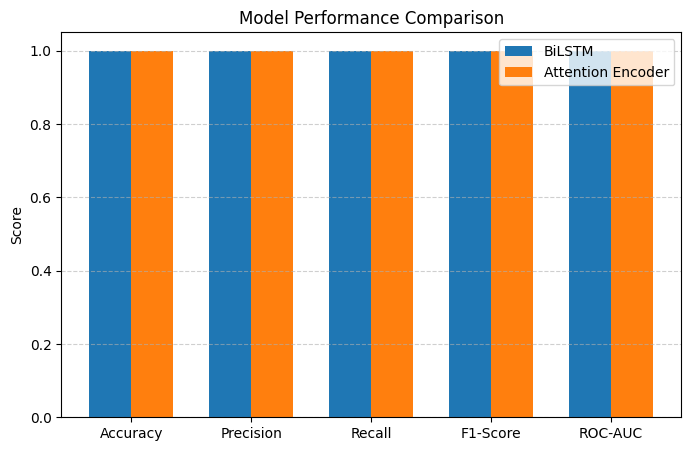

In [5]:
# ==============================
# SECTION 3: EVALUATION & COMPARISON
# ==============================

import torch
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
import matplotlib.pyplot as plt

# ------------------------------
# Function to Evaluate Model
# ------------------------------
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    total_loss = 0.0

    with torch.no_grad():
        for a_ids, b_ids, labels in dataloader:
            a_ids, b_ids, labels = a_ids.to(device), b_ids.to(device), labels.to(device)
            logits = model(a_ids, b_ids)
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0) # Multiply by batch size for total loss

            probs = torch.sigmoid(logits) # Use sigmoid for binary classification
            preds = (probs >= 0.5).long() # Threshold at 0.5 for predictions

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset) # Divide by total number of samples
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary', zero_division=0) # Use binary average
    rec = recall_score(y_true, y_pred, average='binary', zero_division=0) # Use binary average
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0) # Use binary average
    try:
        # ROC-AUC for binary classification requires shape (n_samples,)
        roc_auc = roc_auc_score(y_true, y_probs)
    except Exception:
        roc_auc = np.nan

    print("\nClassification Report (Threshold=0.5):\n", classification_report(y_true, y_pred, zero_division=0))
    print(f"Loss: {avg_loss:.4f} | Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    if not np.isnan(roc_auc):
        print(f"ROC-AUC: {roc_auc:.4f}")

    return acc, prec, rec, f1, roc_auc

# ------------------------------
# Evaluate BiLSTM Baseline
# ------------------------------
print("=== Evaluating BiLSTM Baseline ===")
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
# Use the correct variable name from the previous cell
bilstm_results = evaluate_model(model_bilstm, test_loader, criterion, device)

# ------------------------------
# Evaluate Attention Encoder Baseline
# ------------------------------
print("\n=== Evaluating Attention Encoder Baseline ===")
# Use the correct variable name from the previous cell
attention_results = evaluate_model(model_attn, test_loader, criterion, device)

# ------------------------------
# Combine Results for Comparison
# ------------------------------
results_df = pd.DataFrame({
    'Model': ['BiLSTM', 'Attention Encoder'],
    'Accuracy': [bilstm_results[0], attention_results[0]],
    'Precision': [bilstm_results[1], attention_results[1]],
    'Recall': [bilstm_results[2], attention_results[2]],
    'F1-Score': [bilstm_results[3], attention_results[3]],
    'ROC-AUC': [bilstm_results[4], attention_results[4]]
})

print("\n=== COMPARATIVE RESULTS TABLE ===")
print(results_df.round(4))

# ------------------------------
# Optional: Bar Chart Comparison
# ------------------------------
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, results_df.iloc[0, 1:], width, label='BiLSTM')
rects2 = ax.bar(x + width/2, results_df.iloc[1, 1:], width, label='Attention Encoder')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0, 1.05) # Adjusted y-limit for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [7]:
# ==============================
# SECTION 4: RUNTIME TESTING
# ==============================

import torch
import torch.nn.functional as F
import nltk # Import nltk for tokenization
import json # Import json to load stoi if needed
import os # Import os if loading stoi from file

# ------------------------------
# Load necessary variables if running this cell independently
# (Assumes Section 1 and Section 2 have been run at least once and saved outputs)
# ------------------------------
if 'stoi' not in globals() or 'MAX_SEQ_LEN' not in globals() or 'device' not in globals():
    print("Loading config and stoi...")
    OUT_DIR = "/content/drive/MyDrive/legal_clause_preprocessed"
    config_path = os.path.join(OUT_DIR, "config.json")
    stoi_path = os.path.join(OUT_DIR, "stoi.json")

    if os.path.exists(config_path):
        with open(config_path, "r") as f:
            CONFIG = json.load(f)
        MAX_SEQ_LEN = CONFIG.get('max_seq_len', 128)
        device = torch.device(CONFIG.get('device', 'cuda' if torch.cuda.is_available() else 'cpu'))
        print(f"Loaded MAX_SEQ_LEN: {MAX_SEQ_LEN}, Device: {device}")
    else:
        print("Config file not found. Using default values.")
        MAX_SEQ_LEN = 128
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if os.path.exists(stoi_path):
        with open(stoi_path, "r") as f:
            stoi = json.load(f)
        print(f"Loaded stoi with vocab size: {len(stoi)}")
    else:
        print("stoi file not found. Cannot perform tokenization.")
        stoi = None # Set stoi to None if not found

# Ensure models are on the correct device if they exist
if 'model_bilstm' in globals():
    model_bilstm.to(device)
if 'model_attn' in globals():
    model_attn.to(device)


# ------------------------------
# Helper Function: Predict Clause Similarity
# ------------------------------
def predict_similarity(model, clause1, clause2, stoi, max_len, device):
    """
    Takes two legal clauses as input, processes them,
    and predicts similarity (0 = different, 1 = similar) using a trained model.
    """
    if stoi is None:
        print("Vocabulary (stoi) not loaded. Cannot tokenize.")
        return "Error", 0.0

    model.eval()

    # Simple preprocessing: lowercase + tokenize
    def preprocess_and_tokenize(text):
        # Use nltk word_tokenize for consistency with training
        return nltk.word_tokenize(str(text).lower())

    # Convert words to indices
    def tokens_to_indices(tokens, stoi):
        # Handle potential None or empty tokens list
        if not tokens:
            return []
        return [stoi.get(w, stoi.get("<UNK>", 1)) for w in tokens]

    # Preprocess, tokenize and convert both clauses
    c1_tokens = preprocess_and_tokenize(clause1)
    c2_tokens = preprocess_and_tokenize(clause2)

    c1_indices = tokens_to_indices(c1_tokens, stoi)
    c2_indices = tokens_to_indices(c2_tokens, stoi)


    # Pad or truncate to same max length as training
    def pad_sequence(indices, max_len, pad_idx):
        if len(indices) < max_len:
            return indices + [pad_idx] * (max_len - len(indices))
        else:
            return indices[:max_len]

    pad_idx = stoi.get("<PAD>", 0) # Get padding index, default to 0

    c1_padded = pad_sequence(c1_indices, max_len, pad_idx)
    c2_padded = pad_sequence(c2_indices, max_len, pad_idx)

    c1_tensor = torch.tensor(c1_padded).unsqueeze(0).to(device)
    c2_tensor = torch.tensor(c2_padded).unsqueeze(0).to(device)

    with torch.no_grad():
        # Pass both tensors to the model's forward method
        logits = model(c1_tensor, c2_tensor)
        # Use sigmoid for binary classification probabilities
        probs = torch.sigmoid(logits)
        # For a single pair, the output is a scalar logit, sigmoid gives a scalar probability
        prob_similar = probs.item()

        # Predict class based on threshold
        pred_class = 1 if prob_similar >= 0.5 else 0
        confidence = prob_similar if pred_class == 1 else (1 - prob_similar) # Confidence is the probability of the predicted class

    label = "Similar" if pred_class == 1 else "Not Similar"
    return label, confidence


# ------------------------------
# Example Runtime Testing
# ------------------------------
example_clause_1 = "The borrower shall repay the loan amount within 30 days after termination."
example_clause_2 = "The debtor is obligated to return all borrowed funds within a month after the agreement ends."
example_clause_3 = "This agreement shall be governed by and construed in accordance with the laws of the State of Delaware."


# Check if models are defined before testing
if 'model_bilstm' in globals():
    print("🔹 Testing with BiLSTM Model")
    label_bilstm, conf_bilstm = predict_similarity(
        model_bilstm, example_clause_1, example_clause_2, stoi, MAX_SEQ_LEN, device
    )
    print(f"'{example_clause_1[:50]}...' and '{example_clause_2[:50]}...'")
    print(f"Prediction: {label_bilstm} (Confidence: {conf_bilstm:.4f})\n")

    print("🔹 Testing with BiLSTM Model (Dissimilar Example)")
    label_bilstm_dissimilar, conf_bilstm_dissimilar = predict_similarity(
        model_bilstm, example_clause_1, example_clause_3, stoi, MAX_SEQ_LEN, device
    )
    print(f"'{example_clause_1[:50]}...' and '{example_clause_3[:50]}...'")
    print(f"Prediction: {label_bilstm_dissimilar} (Confidence: {conf_bilstm_dissimilar:.4f})\n")

else:
    print("BiLSTM model not found. Please run the training section first.")


if 'model_attn' in globals():
    print("🔹 Testing with Attention Encoder Model")
    label_attention, conf_attention = predict_similarity(
        model_attn, example_clause_1, example_clause_2, stoi, MAX_SEQ_LEN, device
    )
    print(f"'{example_clause_1[:50]}...' and '{example_clause_2[:50]}...'")
    print(f"Prediction: {label_attention} (Confidence: {conf_attention:.4f})\n")

    print("🔹 Testing with Attention Encoder Model (Dissimilar Example)")
    label_attention_dissimilar, conf_attention_dissimilar = predict_similarity(
        model_attn, example_clause_1, example_clause_3, stoi, MAX_SEQ_LEN, device
    )
    print(f"'{example_clause_1[:50]}...' and '{example_clause_3[:50]}...'")
    print(f"Prediction: {label_attention_dissimilar} (Confidence: {conf_attention_dissimilar:.4f})\n")

else:
     print("Attention Encoder model not found. Please run the training section first.")

Loading config and stoi...
Loaded MAX_SEQ_LEN: 128, Device: cuda
Loaded stoi with vocab size: 30002
🔹 Testing with BiLSTM Model
'The borrower shall repay the loan amount within 30...' and 'The debtor is obligated to return all borrowed fun...'
Prediction: Similar (Confidence: 1.0000)

🔹 Testing with BiLSTM Model (Dissimilar Example)
'The borrower shall repay the loan amount within 30...' and 'This agreement shall be governed by and construed ...'
Prediction: Not Similar (Confidence: 1.0000)

🔹 Testing with Attention Encoder Model
'The borrower shall repay the loan amount within 30...' and 'The debtor is obligated to return all borrowed fun...'
Prediction: Similar (Confidence: 1.0000)

🔹 Testing with Attention Encoder Model (Dissimilar Example)
'The borrower shall repay the loan amount within 30...' and 'This agreement shall be governed by and construed ...'
Prediction: Not Similar (Confidence: 1.0000)

